In [2]:
%load_ext autoreload

%autoreload 2

In [36]:
from __future__ import division
from glob import glob
import os
import time
import cPickle as pickle
import subprocess

import scipy.linalg
import scipy.stats

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rc("figure", dpi=144)

import astropy.io.fits
import astropy.table
import astropy.units as u
import astropy.constants as c
import astropy.time

import emcee
import numdifftools

import kepler
import threebody

import logging
logger = logging.getLogger()
#logger.setLevel(logging.DEBUG)
logger.setLevel(logging.INFO)
logging.debug("test")

In [4]:
!ls -ltr *.tim

-rw-r--r-- 1 aarchiba aipsuser     3194 May 31  2013 0337-short-2.tim
-rw-r--r-- 1 aarchiba aipsuser  1709289 May 31  2013 0337+17.tim
-rw-r--r-- 1 aarchiba aipsuser    10646 May 31  2013 0337-short.tim
-rw-r--r-- 1 aarchiba aipsuser  1870476 Jun 17  2013 0337+17-scott-2013-06-06.tim
-rw-r--r-- 1 aarchiba aipsuser  6961347 Jul 31  2013 synthetic.tim
-rw-r--r-- 1 aarchiba aipsuser  1977505 Aug 15  2013 0337+17-scott-2013-08-15.tim
-rw-r--r-- 1 aarchiba aipsuser  2043963 Aug 30  2013 0337+17-scott-2013-08-29.tim
-rw-r--r-- 1 aarchiba aipsuser  1590000 Sep 19  2013 fake-pulsar.tim
-rw-r--r-- 1 aarchiba aipsuser  2078907 Jan 22  2014 0337+17-scott-2014-01-22.tim
-rw-r--r-- 1 aarchiba aipsuser  2201549 Jan 28  2014 0337+17-anne-2014-01-28.tim
-rw-r--r-- 1 aarchiba aipsuser      154 Feb  4  2014 0337+17-anne-2014-02-04.tim
-rw-r--r-- 1 aarchiba aipsuser  2186806 Feb  4  2014 0337+17-anne-2014-02-04b.tim
-rw-r--r-- 1 aarchiba aipsuser  2143978 Feb 10  2014 fake-t2.tim
-rw-r--r-- 1 aarchiba ai

## Loading in pipeline tim files

In [13]:
processing_name = "tuned2"
toa_name = "aligned"
fpickle = "forecaster_params.pickle"
fparams = "forecaster_best_parameters.pickle"
d = pickle.load(open(fpickle,"rb"))
d["files"] = "%s_%s" % (processing_name, toa_name)
d["toa_mode"] = "pipeline"
F = threebody.Fitter(**d)
F.best_parameters = pickle.load(open(fparams, "rb"))
d

{'efac': 1,
 'fdn_range': (1, 5),
 'files': 'tuned2_aligned',
 'fit_pm': True,
 'fit_pos': True,
 'fit_px': True,
 'general': True,
 'kopeikin': False,
 'linear_dm': True,
 'linear_jumps': True,
 'matrix_mode': 0,
 'only_tels': None,
 'parfile': '0337_tempo2_px_optical_dmcorr.par',
 'ppn_mode': 'GR',
 'priors': ('dbeta', 'dgamma'),
 'reference_f0': 365.95336876828094,
 'shapiro': True,
 'special': True,
 't2_astrometry': True,
 'toa_mode': 'pipeline',
 'tol': 1e-16,
 'tzrmjd_middle': 'auto',
 'use_quad': False}

In [14]:
for t in F.jnames:
    if t not in F.best_parameters:
        print t
        F.best_parameters[t] = 0

j_AO_350
j_AO_430
j_WSRT_350


In [15]:
toa_info = threebody.read_t2_toas(F.files+".tim")
len(toa_info)

33971

In [56]:
outline = "OUTPUT {solarangle} {ipm}\n"
output = subprocess.check_output(["tempo2",
                                  "-nobs", str(len(toa_info)+100),
                                  "-npsr", "1",
                                  "-output", "general2",
                                  "-s", outline,
                                  "-f", F.parfile,
                                  F.files+".tim"])

In [63]:
sas = []
ipms = []
for l in output.split("\n"):
    if not l.startswith("OUTPUT"):
        continue
    sas.append(float(l.split()[1]))
    ipms.append(float(l.split()[2]))
if len(sas)!=len(toa_info):
    raise ValueError
for t, s, i in zip(toa_info,sas,ipms):
    t["flags"]["solarangle"] = s
    t["flags"]["ipm"] = i
    

 2.1307799057 144.295400685


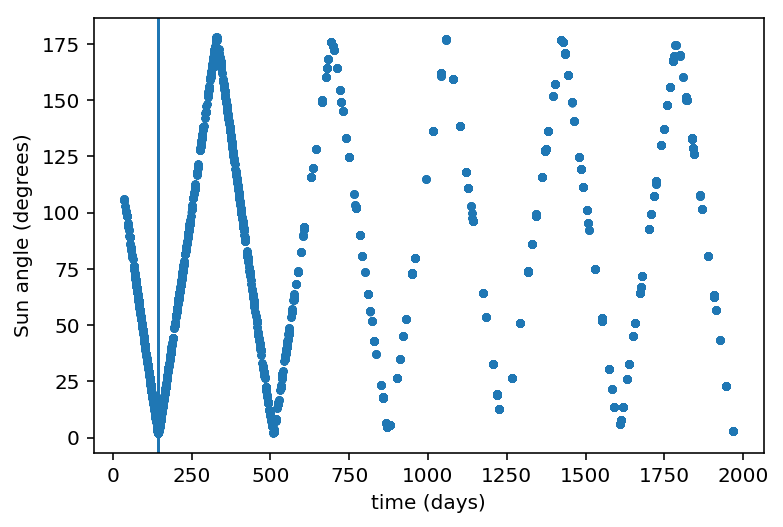

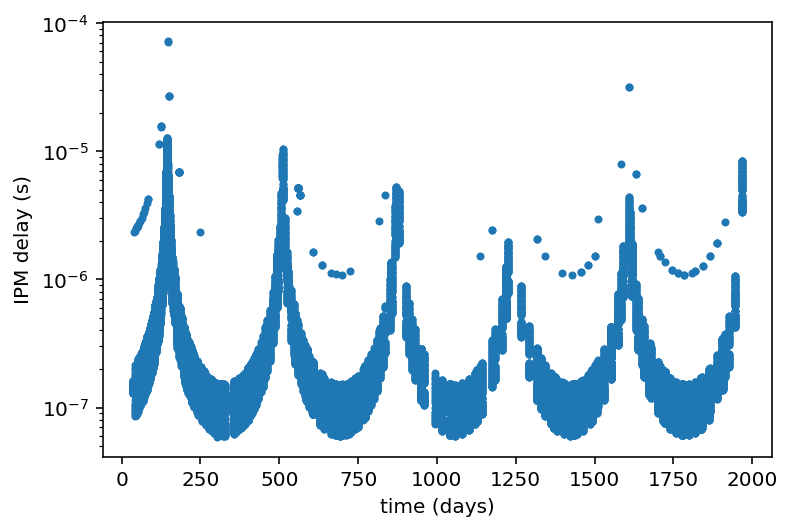

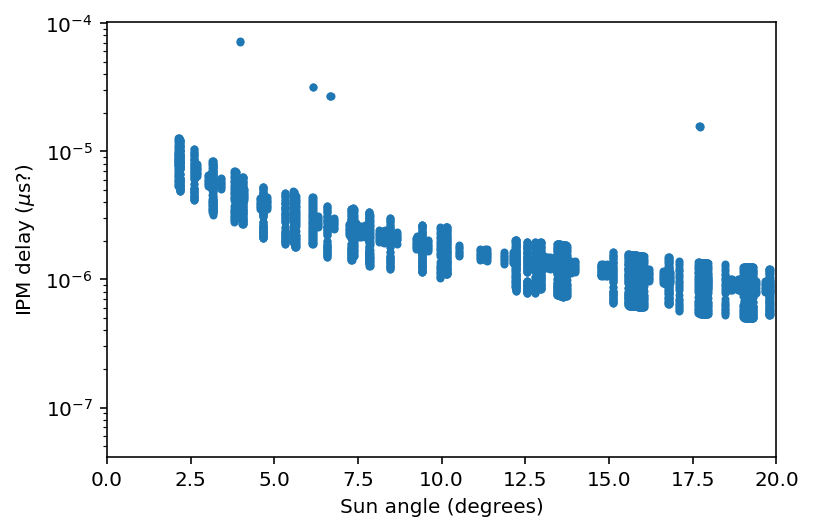

In [107]:
plt.plot(F.mjds, sas, ".")
plt.xlabel("time (days)")
plt.ylabel("Sun angle (degrees)")
plt.figure()
plt.semilogy(F.mjds, ipms, ".")
plt.xlabel("time (days)")
plt.ylabel("IPM delay (s)")
plt.savefig("ipm-delay.pdf")
plt.figure()
plt.semilogy(sas, ipms, ".")
plt.xlabel("Sun angle (degrees)")
plt.ylabel("IPM delay ($\mu$s?)")
plt.xlim(0,20)
print np.amin(sas), F.mjds[np.argmin(sas)]

In [65]:
if F.pulses is None:
    F.pulses = np.zeros(len(F.mjds),dtype=np.int64)

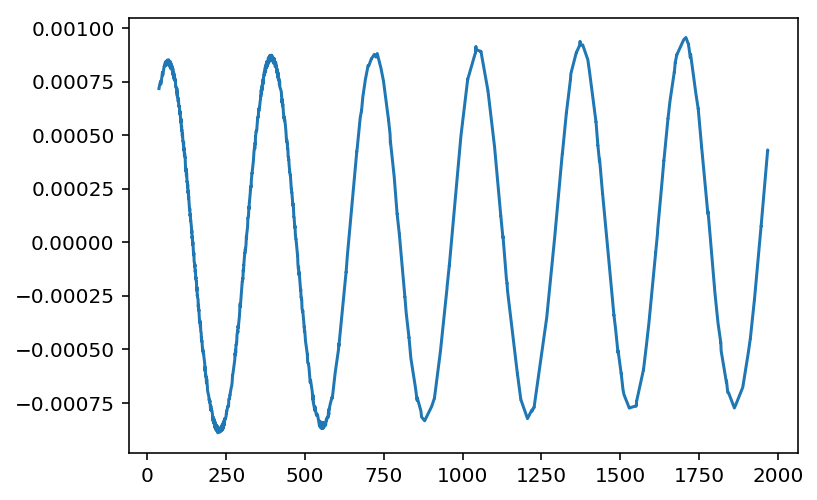

In [66]:
o = F.compute_orbit(F.best_parameters)
plt.plot(F.mjds, F.mjds-o["t_psr"])

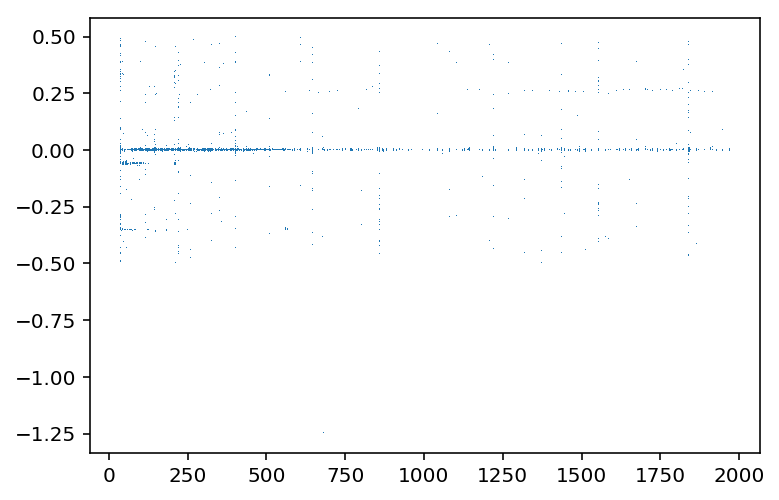

In [67]:
r = F.residuals(F.best_parameters, linear_fit=False)
plt.plot(F.mjds,r, ",")

In [68]:
F.pulses += np.round(r).astype(np.int64)

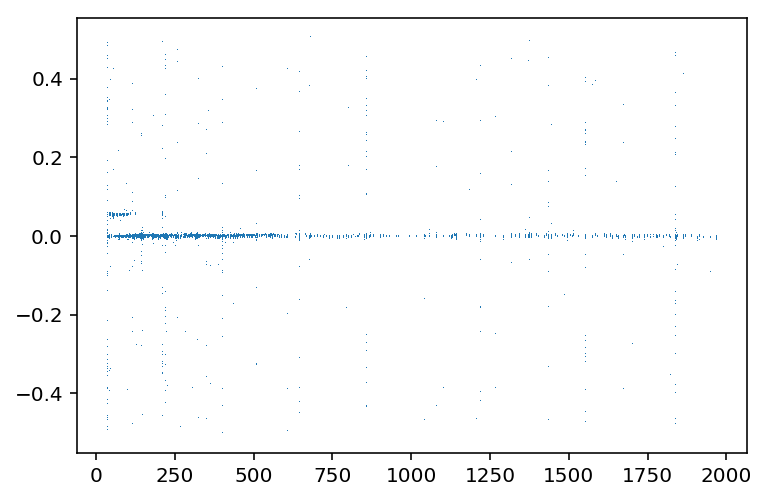

In [69]:
r = F.residuals(F.best_parameters)
res = r

plt.plot(F.mjds,res, ",")

nothing for ('AO', 350)
('GBT', 1400) -0.000569895752274
('WSRT', 1400) 9.35032567723e-05
('AO', 1400) 0.000533952660255
('AO', 430) -0.000131782605067
('WSRT', 350) -0.000103050124551


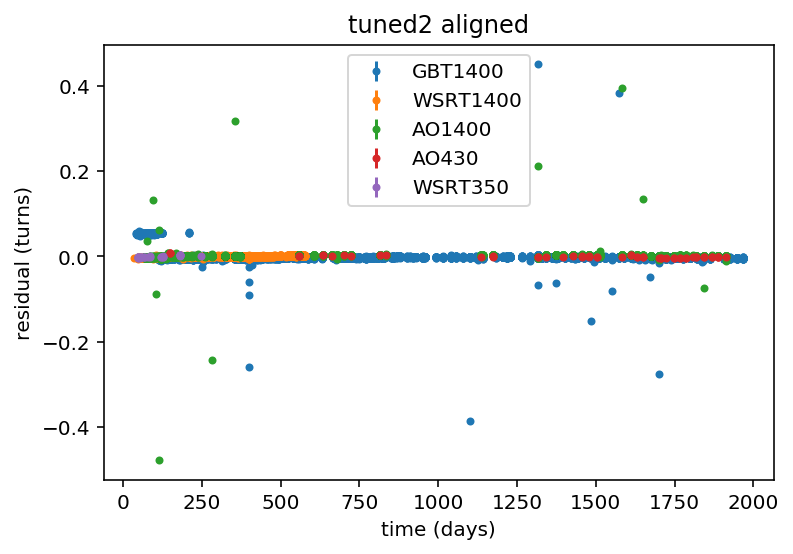

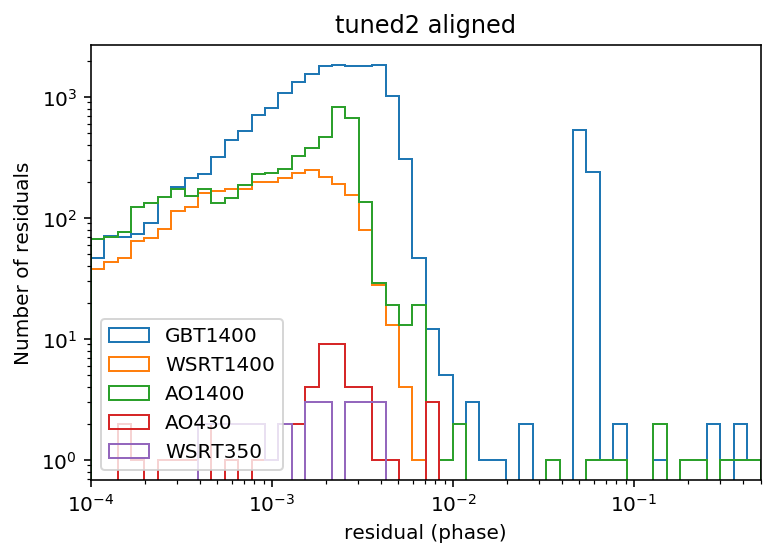

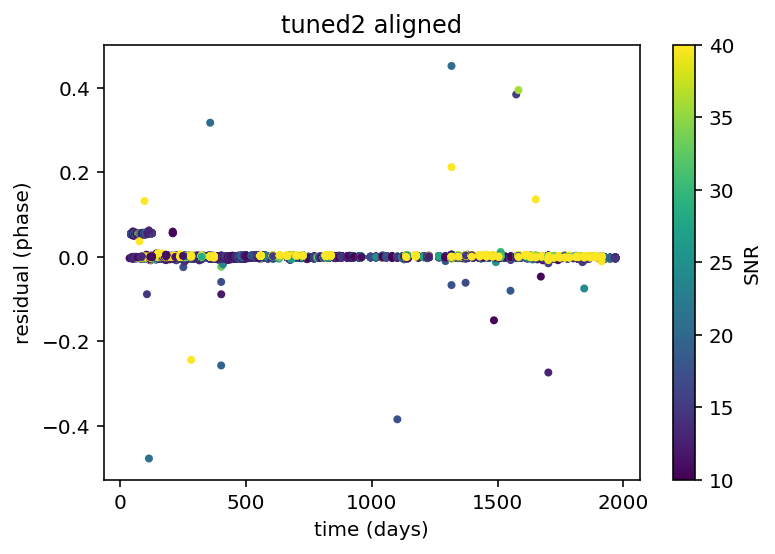

In [70]:
plt.figure(1)
plt.figure(2)
plt.figure(3)

cm = plt.get_cmap("viridis")
cNorm  = matplotlib.colors.Normalize(vmin=10, vmax=40)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cm)

def key(t):
    return t["flags"]["tel"], int(t["flags"]["band"])
def wrap(a,center=0):
    return (a+0.5-center) % 1 - 0.5 + center
def fmtk(k):
    return "%s%s" % k
subsets = {}
snrs = np.zeros(len(toa_info))

be = 10**np.linspace(np.log10(1e-4),np.log10(0.5),50+1)

for i,t in enumerate(toa_info):
    k = key(t)
    if k not in subsets:
        subsets[k] = np.zeros(len(toa_info),dtype=bool)
    snr = float(t["flags"]["snr"])
    snrs[i] = snr
    if snr>10:
        subsets[k][i] = True

for k,c in subsets.items():
    if not np.any(c):
        print "nothing for", k
        continue
    m = wrap(scipy.stats.circmean(res[c], high=1))
    print k, m
    r = wrap(res[c],m)
    plt.figure(1)
    plt.errorbar(F.mjds[c], r, F.uncerts[c], linestyle="none", marker=".", label=fmtk(k))
    plt.figure(2)
    plt.hist(np.abs(r-m),histtype="step",range=(0,0.5),bins=be, label=fmtk(k))
    plt.figure(3)
    #colors = [scalarMap.to_rgba(s) for s in snrs[c]]
    plt.scatter(F.mjds[c], r-m, marker=".", c=snrs[c], vmin=10, vmax=40)
    
plt.figure(1)
plt.legend(loc="best")
plt.xlabel("time (days)")
plt.ylabel("residual (turns)")
plt.title("%s %s" % (toa_info[0]["flags"]["processing_name"],toa_info[0]["flags"]["toa_name"]))
plt.savefig("outliers-raw.pdf")
plt.figure(2)
plt.xlim(be[0],be[-1])
plt.legend(loc="lower left")
plt.gca().set_yscale('log',nonposy='clip')
plt.gca().set_xscale('log')             
plt.xlabel("residual (phase)")
plt.ylabel("Number of residuals")
plt.title("%s %s" % (toa_info[0]["flags"]["processing_name"],toa_info[0]["flags"]["toa_name"]))
plt.savefig("outliers-dist.pdf")
plt.figure(3)
plt.title("%s %s" % (toa_info[0]["flags"]["processing_name"],toa_info[0]["flags"]["toa_name"]))
plt.xlabel("time (days)")
plt.ylabel("residual (phase)")
plt.colorbar(label="SNR")
plt.savefig("outliers-snr.pdf")



In [71]:
masks = {}
ix_inv = np.argsort(F.ix)
for (i,t) in enumerate(toa_info):
    k = key(t)
    if k not in masks:
        masks[k] = np.zeros(len(toa_info), dtype=bool)
    i_array = ix_inv[i] # FIXME: this or inverse?
    f = t["flags"]
    if float(f["snr"])<10:
        continue
    if "mode" in f and f["mode"]=="search":
        continue
    masks[k][i_array] = True


In [72]:
means = {}
for k, c in masks.items():
    m = wrap(scipy.stats.circmean(res[c], high=1))
    print k, m, np.sum(c)
    means[k] = m

('AO', 350) nan 0
('GBT', 1400) -0.00274015235225 18691
('WSRT', 1400) 9.53854457845e-05 3271
('AO', 1400) 0.000540917759188 5573
('AO', 430) -0.000119325437004 54
('WSRT', 350) -6.60511758677e-05 29


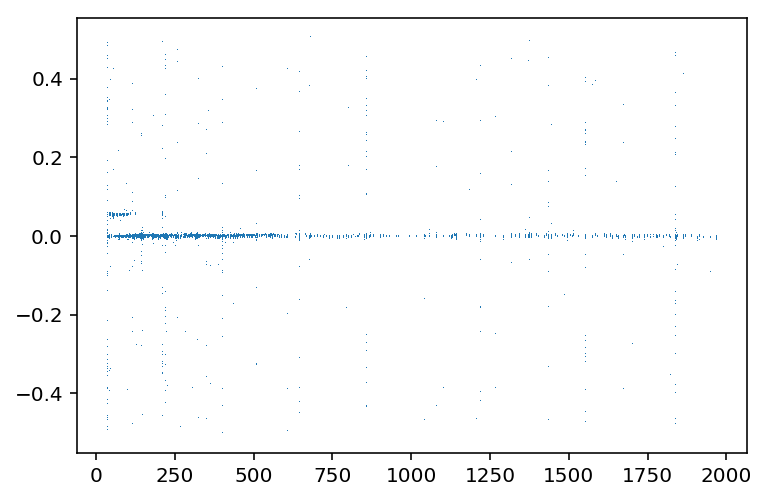

In [73]:
r = F.residuals(F.best_parameters)
plt.plot(F.mjds, r, ",")

In [74]:

for (i,t) in enumerate(toa_info):
    k = key(t)
    i_array = ix_inv[i] # FIXME: this or inverse?
    if np.isnan(means[k]):
        dp = 0
    else:
        dp = np.round(r[i_array]-means[k])
    if dp!=0:
        print r[i_array]-means[k], t["mjd"]
    F.pulses[i_array] += dp
    t["flags"]["pn"] = str(F.pulses[i_array])

0.505079977878 56599.2276279


In [75]:
threebody.write_t2_toas("%s_%s_pulses.tim"
                        % (processing_name, toa_name),
                        toa_info)

In [95]:
clean_toa_info = []
for t in toa_info:
    k = key(t)
    f = t["flags"]
    if float(f["snr"])<10:
        continue
    if "mode" in f and f["mode"]=="search":
        continue
    clean_toa_info.append(t)
threebody.write_t2_toas("%s_%s_pulses_selected.tim"
                        % (processing_name, toa_name),
                        clean_toa_info)
print len(clean_toa_info), len(toa_info)

27618 33971


In [100]:
toa_info_5deg = []
for t in clean_toa_info:
    k = key(t)
    f = t["flags"]
    if f["solarangle"]<5:
        continue
    toa_info_5deg.append(t)
threebody.write_t2_toas("%s_%s_pulses_5deg.tim"
                        % (processing_name, toa_name),
                        toa_info_5deg)
print len(toa_info_5deg), len(clean_toa_info), len(toa_info)

27221 27618 33971


In [96]:
toa_info_1400 = []
for t in clean_toa_info:
    k = key(t)
    f = t["flags"]
    if t["freq"]<1000:
        continue
    toa_info_1400.append(t)
threebody.write_t2_toas("%s_%s_pulses_1400.tim"
                        % (processing_name, toa_name),
                        toa_info_1400)
print len(toa_info_1400), len(clean_toa_info), len(toa_info)

27535 27618 33971


In [97]:
toa_info_1400_nosun = []
for t in toa_info_1400:
    k = key(t)
    f = t["flags"]
    #if f["ipm"]>3e-6:
    #    continue
    if f["solarangle"]<15:
        continue
    toa_info_1400_nosun.append(t)
threebody.write_t2_toas("%s_%s_pulses_1400_nosun.tim"
                        % (processing_name, toa_name),
                        toa_info_1400_nosun)
print len(toa_info_1400_nosun), len(toa_info_1400), len(clean_toa_info), len(toa_info)

25153 27535 27618 33971


In [98]:
toa_info_1400_nosun2 = []
for t in toa_info_1400:
    k = key(t)
    f = t["flags"]
    #if f["ipm"]>3e-6:
    #    continue
    if f["solarangle"]<5:
        continue
    toa_info_1400_nosun2.append(t)
threebody.write_t2_toas("%s_%s_pulses_1400_nosun2.tim"
                        % (processing_name, toa_name),
                        toa_info_1400_nosun2)
print len(toa_info_1400_nosun2), len(toa_info_1400)

27138 27535


In [101]:
for tel in ["AO","GBT","WSRT"]:
    ts = []
    for t in toa_info_5deg:
        if t["flags"]["tel"] == tel:
            ts.append(t)
    threebody.write_t2_toas("%s_%s_pulses_5deg_%s.tim"
                        % (processing_name, toa_name, tel),
                        ts)
    print(tel, len(ts), len(toa_info_5deg), 
          len(clean_toa_info), len(toa_info))

('AO', 5437, 27221, 27618, 33971)
('GBT', 18487, 27221, 27618, 33971)
('WSRT', 3297, 27221, 27618, 33971)


## Check out cleaned-up tim file

In [ ]:
fpickle = "forecaster_params.pickle"
d = pickle.load(open(fpickle,"rb"))
d["files"] = ("%s_%s_pulses_1400"
                        % (processing_name, toa_name))
d["toa_mode"] = "pipeline"
Fc = threebody.Fitter(**d)
Fc.best_parameters = F.best_parameters
d

In [ ]:
r = Fc.residuals()
res = r
plt.plot(res, ",")
plt.figure()
plt.plot(Fc.mjds, res, ",")
print len(res)